Выполнено Олейник Софией в рамках дисциплины "Аналитика данных на Python" магистратуры ИТМО.

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import fcluster, linkage


In [8]:
# считываем данные с явным указанием типа
data = pd.read_csv(
    "data/Econom_Cities_data.csv",
    sep=";",
    decimal=",",
    dtype = {
        "City": str,
        "Work": int,
        "Price": float,
        "Salary": float
    }
)
data.set_index("City", inplace=True)

In [9]:
# очистка данных от выбросов
data_cleaned = data.copy()
for col in data.columns:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    data_cleaned = data_cleaned[(data_cleaned[col] >= lower) & (data_cleaned[col] <= upper)]

In [10]:
# стандартизация данных
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_cleaned)
data_scaled = pd.DataFrame(data_scaled, columns=data_cleaned.columns, index=data_cleaned.index)

In [11]:
# подбор параметров DBSCAN
eps_values = [0.3, 0.5, 0.7, 1.0]
min_samples_values = [3, 5, 7]

best_eps = None
best_min_samples = None
best_silhouette = -1

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(data_scaled)

        # проверяем, что есть как минимум 2 кластера и нет шума
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        if n_clusters > 1 and len(set(labels)) > 1:
            silhouette_avg = silhouette_score(data_scaled, labels)
            if silhouette_avg > best_silhouette:
                best_silhouette = silhouette_avg
                best_eps = eps
                best_min_samples = min_samples

print(f"Лучшие параметры: eps={best_eps}, min_samples={best_min_samples}")
print(f"Лучший silhouette score: {best_silhouette:.3f}")

Лучшие параметры: eps=1.0, min_samples=7
Лучший silhouette score: 0.356


In [12]:
# применение DBSCAN с лучшими параметрами
dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
labels = dbscan.fit_predict(data_scaled)

data_cleaned['cluster'] = labels

# статистика по кластерам
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)

print(f"Количество кластеров: {n_clusters}")
print(f"Количество шумовых точек: {n_noise}")
print(f"Процент шума: {n_noise/len(labels)*100:.1f}%")

Количество кластеров: 2
Количество шумовых точек: 9
Процент шума: 20.0%


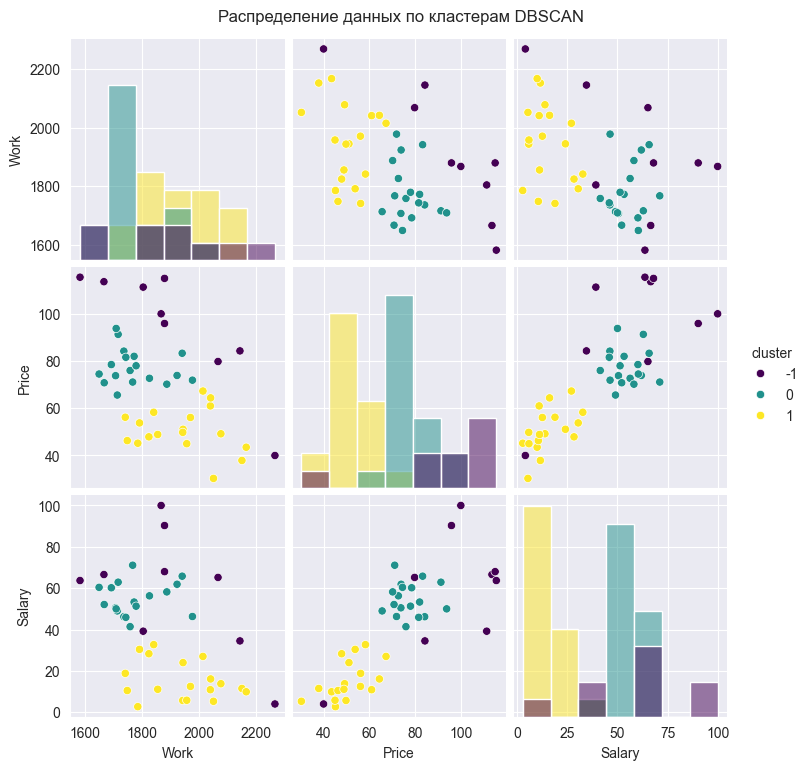

In [13]:
# визуализация результатов DBSCAN
sns.pairplot(data_cleaned, hue='cluster', palette='viridis', diag_kind='hist')
plt.suptitle(f'Распределение данных по кластерам DBSCAN', y=1.02)
plt.show()

In [14]:
# анализ характеристик кластеров
if n_clusters > 0:
    print("Статистика по кластерам DBSCAN:")
    cluster_stats = data_cleaned[data_cleaned['cluster'] != -1].groupby('cluster').describe()
    print(cluster_stats)

    # шумовые точки
    if n_noise > 0:
        print("\nШумовые точки:")
        print(data_cleaned[data_cleaned['cluster'] == -1].index.tolist())

Статистика по кластерам DBSCAN:
         Work                                                             \
        count         mean         std     min      25%     50%      75%   
cluster                                                                    
0        18.0  1776.666667   96.728243  1650.0  1711.00  1751.5  1815.25   
1        18.0  1942.055556  134.324222  1742.0  1829.25  1951.5  2041.75   

                Price             ...               Salary             \
            max count       mean  ...     75%   max  count       mean   
cluster                           ...                                   
0        1978.0  18.0  77.400000  ...  81.900  93.8   18.0  54.600000   
1        2167.0  18.0  50.677778  ...  56.175  67.3   18.0  15.388889   

                                                   
              std   min    25%   50%    75%   max  
cluster                                            
0        7.964111  41.4  49.25  52.7  60.35  71.1  
1        9.33

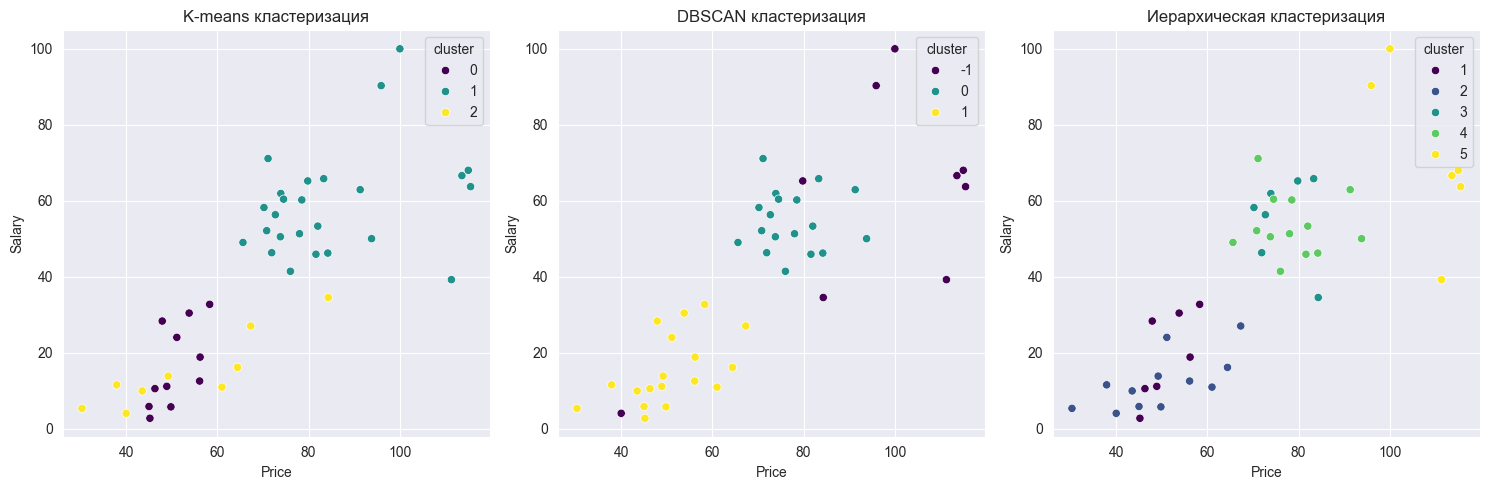

In [17]:
# сравнение методов кластеризации
plt.figure(figsize=(15, 5))

# K-means
plt.subplot(1, 3, 1)
kmeans_data = data_cleaned.copy()
kmeans_labels = KMeans(n_clusters=3, random_state=42, n_init=10).fit_predict(data_scaled)
kmeans_data['cluster'] = kmeans_labels
sns.scatterplot(data=kmeans_data, x='Price', y='Salary', hue='cluster', palette='viridis')
plt.title('K-means кластеризация')

# DBSCAN
plt.subplot(1, 3, 2)
dbscan_data = data_cleaned.copy()
sns.scatterplot(data=dbscan_data, x='Price', y='Salary', hue='cluster', palette='viridis')
plt.title('DBSCAN кластеризация')

# иерархическая
plt.subplot(1, 3, 3)
hierarchical_link = linkage(data_scaled, 'ward', 'euclidean')
hierarchical_labels = fcluster(hierarchical_link, 3.5, criterion='distance')
hierarchical_data = data_cleaned.copy()
hierarchical_data['cluster'] = hierarchical_labels
sns.scatterplot(data=hierarchical_data, x='Price', y='Salary', hue='cluster', palette='viridis')
plt.title('Иерархическая кластеризация')

plt.tight_layout()
plt.show()

In [19]:
# выводы по кластеризации
print("СРАВНЕНИЕ МЕТОДОВ КЛАСТЕРИЗАЦИИ:")

# K-means
kmeans_silhouette = silhouette_score(data_scaled, kmeans_labels)
print(f"K-means: silhouette score = {kmeans_silhouette:.3f}")

# DBSCAN
if n_clusters > 1:
    dbscan_silhouette = silhouette_score(data_scaled[labels != -1], labels[labels != -1])
    print(f"DBSCAN: silhouette score = {dbscan_silhouette:.3f}")
    print(f"DBSCAN: процент шума = {n_noise/len(labels)*100:.1f}%")

# иерархическая
hierarchical_silhouette = silhouette_score(data_scaled, hierarchical_labels)
print(f"Иерархическая: silhouette score = {hierarchical_silhouette:.3f}")

СРАВНЕНИЕ МЕТОДОВ КЛАСТЕРИЗАЦИИ:
K-means: silhouette score = 0.386
DBSCAN: silhouette score = 0.515
DBSCAN: процент шума = 20.0%
Иерархическая: silhouette score = 0.383
